In [1]:
import sys
# This makes the gdc19 package avaialble
sys.path.append('../')

In [2]:
import gdc19
import PVGeo
import vtki
import omfvtk
import lasio

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

-----

# File IO

This notebook runs through all of the data files given in the project and reads them into useable, spatially-referenced data object.

In [4]:
# Be sure to set your working directory!!!
# this is the path to the Google Drive folder
gdc19.set_data_directory('/Volumes/GoogleDrive/My Drive/utah-forge')

'/Volumes/GoogleDrive/My Drive/utah-forge'

-----
## Well Data

Incomplete.

We'll use some of [`lasio`](https://lasio.readthedocs.io/en/latest/) for the file IO

In [5]:
las = lasio.read(gdc19.get_well_path(r'Acord 1-26_digitized_geophysical_well_log.las'))
las.curvesdict.keys()

dict_keys(['DEPT', 'BAD_RHOB', 'BITSIZE', 'CALI', 'DRHO', 'DT', 'GAMMA_RAY_SPLICE', 'GR_PROCESS', 'GR_SPLICE', 'LLD_SPLICE', 'LLM_SPLICE', 'LLS_SPLICE', 'NEUTRON_SPLICE', 'RHOB_PROCESSING', 'RHOB_SPLICE', 'SP_SLICE', 'TEMPERATURE_DEEP', 'TEMPERATURE_SHALLOW'])

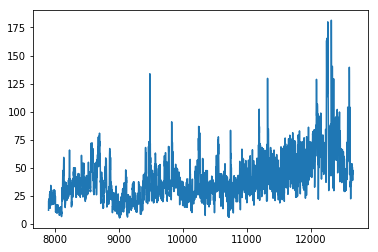

In [6]:
plt.plot(las.index, las["GAMMA_RAY_SPLICE"])

## Surfaces

Load in the 3D surface files

In [7]:
surfaces = vtki.MultiBlock()

In [8]:
def grid_surface(points):
    """Inserts structured points onto a grid 
    and adds an elevation filter
    """
    points[:, 1] = points[::-1, 1]
    xu = np.unique(points[:, 0])
    yu = np.unique(points[:, 1])
    xx, yy = np.meshgrid(xu, yu)
    zz = points[:, 2].reshape(xx.shape)
    zz = np.flip(zz, axis=0)
    # Remove the last row because this is buggy
    xx = xx[0:-2, :]
    yy = yy[0:-2, :]
    zz = zz[0:-2, :]
    return vtki.StructuredGrid(xx, yy, zz).elevation()

def read_surface_verts(filename, grid=False):
    surf = pd.read_csv(gdc19.get_surfaces_path(filename))
    if grid:
        return grid_surface(surf.values)
    return PVGeo.pointsToPolyData(surf.values)


In [9]:
gdc19.list_filenames('surfaces')

['land_surface_vertices.csv',
 'top_granitoid_vertices.csv',
 'Negro_Mag_Fault_vertices.csv',
 '175C_vertices.csv',
 'Opal_Mound_Fault_vertices.csv',
 '225C_vertices.csv']

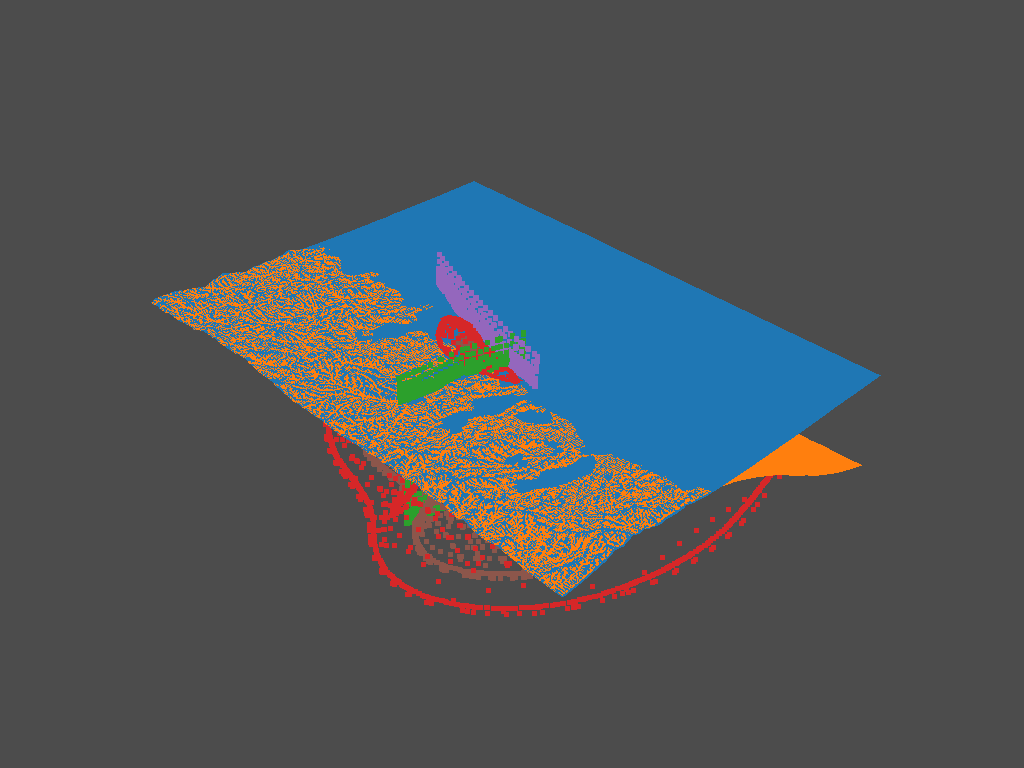

In [18]:
surfaces[0, 'land_surface'] = read_surface_verts('land_surface_vertices.csv', grid=True)
surfaces[1, 'top_granitoid'] = read_surface_verts('top_granitoid_vertices.csv', grid=True)
surfaces[2, 'negro_mag_fault']  = read_surface_verts('Negro_Mag_Fault_vertices.csv')
surfaces[3, '175c'] = read_surface_verts('175C_vertices.csv')
surfaces[4, 'opal_mound_fault'] = read_surface_verts('Opal_Mound_Fault_vertices.csv')
surfaces[5, '225c'] = read_surface_verts('225C_vertices.csv')
surfaces.plot(notebook=True, showedges=False, multi_colors=True)

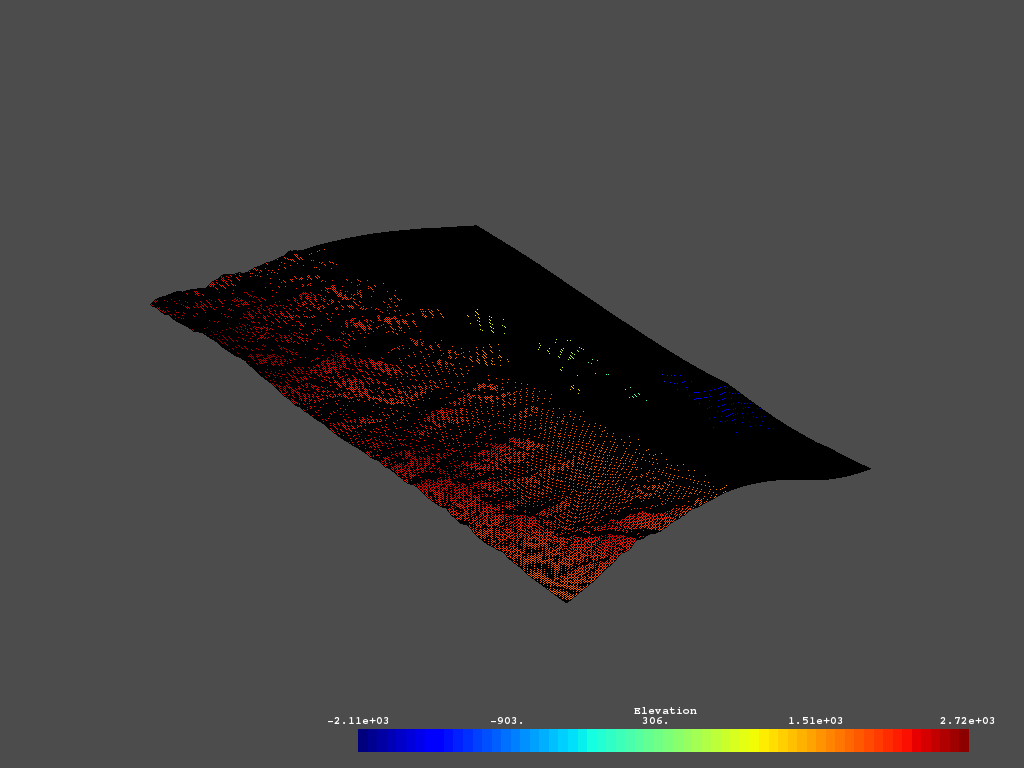

In [11]:
surfaces['top_granitoid'].plot()#.save('top_granitoid.vtk')

In [12]:
arr = np.linspace(0,100,100)
arr

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

## Temperature Data

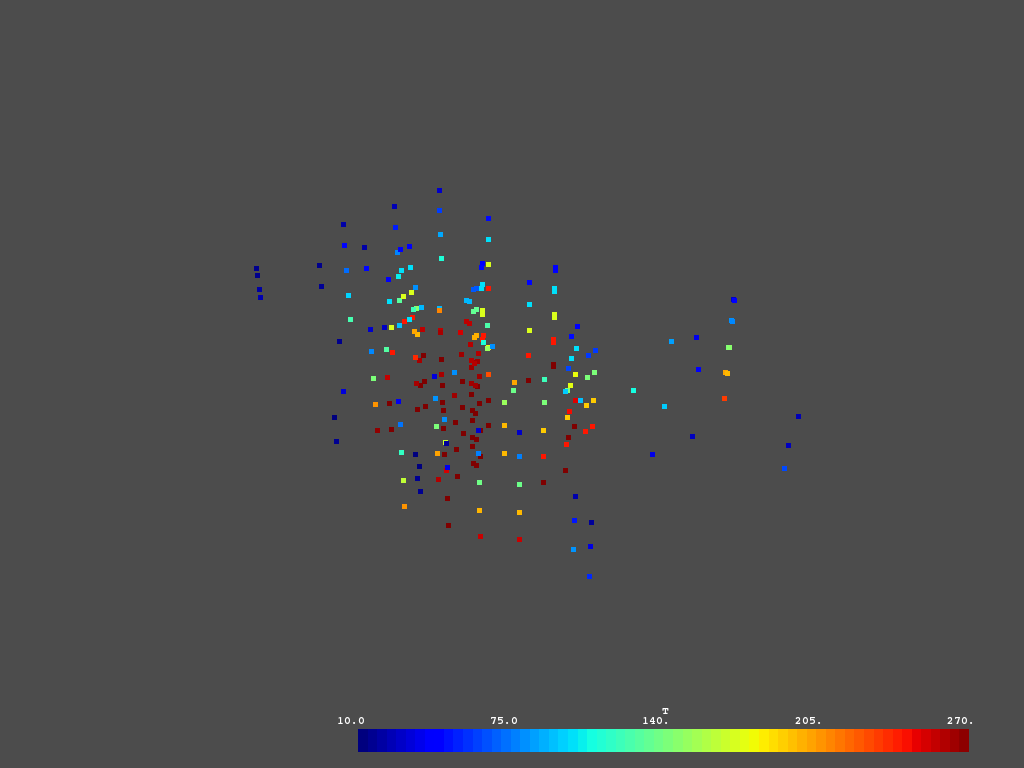

In [13]:
# Temperature data
temp = PVGeo.pointsToPolyData(
        pd.read_csv(
            gdc19.get_temperature_path('well_based_temperature.csv')
            )
        )
temp.plot(notebook=True)

## Injection Data

Not sure how to use these data yet...

In [14]:
injections = []
for f in gdc19.list_filenames('injection'):
    injections.append(pd.read_csv(gdc19.get_injection_path(f)))

In [15]:
injections[0].head()

,Time (hr),Pressure (psi),Pressure (MPa)
0,0.000000,11.839995,0.081634
1,0.001389,11.839508,0.081631
2,0.002778,11.848282,0.081691
3,0.004167,11.853885,0.081730
4,0.005556,11.858296,0.081760


In [16]:
injections[1].head()

,Time (hr),Flow (barrel/min),Flow (Liter/min)
0,13.152500,0.1,15.898729
1,13.152778,0.2,31.797459
2,13.153056,0.2,31.797459
3,13.153333,0.2,31.797459
4,13.153611,0.3,47.696188


## Drilling

Not sure yet

## GIS Data

I'll get around to this

In [17]:
import matplotlib as mpl
import collections